In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows 기준 Malgun Gothic, Mac은 AppleGothic으로 변경)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 소매만매액데이터 로드
df_raw = pd.read_csv('data/소매판매액지수(1995.1~).csv', encoding='cp949')
# 데이터 전처리 (가로 -> 세로 변환)
dates = df_raw.columns[1:]
values = df_raw.iloc[1, 1:].values
df = pd.DataFrame({'Retail_Index': values}, index=dates)
df.index.name = '날짜'
# 날짜 형식 변환 및 정렬
df.index = df.index.str.replace(r'[^\d.]', '', regex=True)
df.index = pd.to_datetime(df.index, format='%Y.%m')
df = df.sort_index()
# 날짜 범위 설정 (2004년 1월 1일부터 2026년 2월 1일까지)
start_date = '2004-01-01'
end_date = '2026-02-01'
df = df[(df.index >= start_date) & (df.index <= end_date)]
# 숫자 변환
df['Retail_Index'] = pd.to_numeric(df['Retail_Index'])
#  12개월 누적 로그 변화율 및 Z-Score 계산
df['log_index'] = np.log(df['Retail_Index'])
df['12m_log_return'] = df['log_index'].diff(12)
mean_val = df['12m_log_return'].mean()
std_val = df['12m_log_return'].std()
df['z_score'] = (df['12m_log_return'] - mean_val) / std_val
# 저장
output_filename = 'data/data_z_score/new_Retail_Sales_Z_Score.csv'
df.to_csv(output_filename, encoding='utf-8-sig')
print(f"'{output_filename}' 파일이 저장되었습니다.")
# 결과 확인
print(df[['Retail_Index', '12m_log_return', 'z_score']].tail())

'data/data_z_score/new_Retail_Sales_Z_Score.csv' 파일이 저장되었습니다.
            Retail_Index  12m_log_return   z_score
날짜                                                
2025-08-01          99.3       -0.004020 -0.806393
2025-09-01         106.2        0.021895 -0.075013
2025-10-01         103.9        0.003857 -0.584078
2025-11-01         105.5        0.007612 -0.478117
2025-12-01         107.1        0.012212 -0.348279


파일이 'data/data_z_score/(사용액)신용카드_Z_Score_2005_2026.csv'로 저장되었습니다.
            card_spending  12m_log_return   z_score
date                                               
2025-07-01     94958632.0        0.053026 -0.025623
2025-08-01     91516719.0        0.033531 -0.427084
2025-09-01     95364571.0        0.067959  0.281906
2025-10-01     92592210.0        0.016660 -0.774494
2025-11-01     93619698.0        0.044298 -0.205345


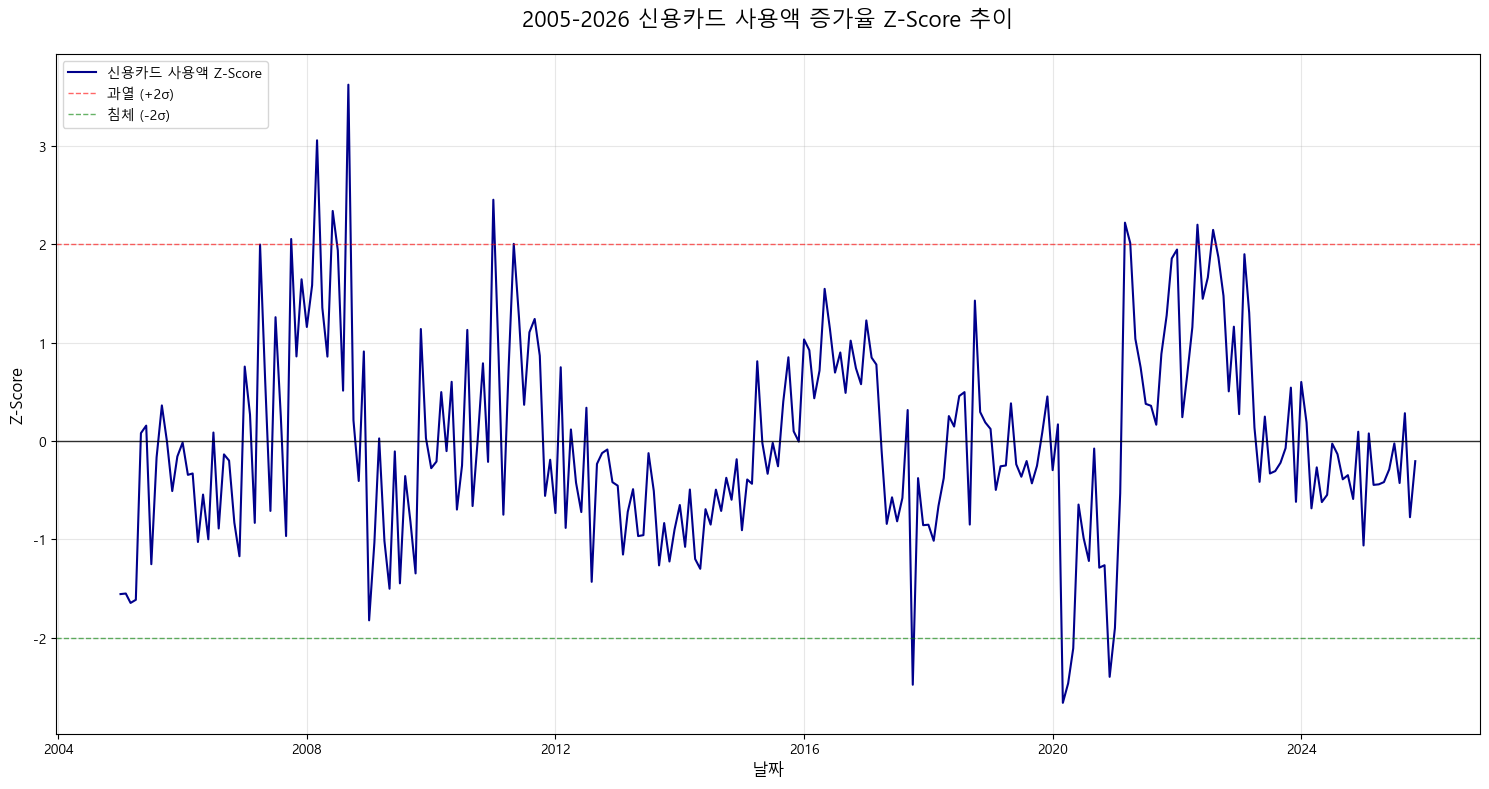

In [3]:
# 파일 읽기 (인코딩 자동 처리)
try:
    df_raw = pd.read_csv('data/신용카드사용액(2003.1~) (1).csv', encoding='utf-8-sig')
except:
    df_raw = pd.read_csv('data/신용카드사용액(2003.1~) (1).csv', encoding='cp949')
# 데이터 구조 변환
# 6번째 열(index 5)부터 날짜 데이터('Jan-03')가 시작됩니다.
dates = df_raw.columns[6:]
values = df_raw.iloc[0, 6:].values
# 데이터프레임 생성
df = pd.DataFrame({'card_spending': values}, index=dates)

# 날짜 형식 변환 ('2003/01' -> '2003-01-01')
df.index = pd.to_datetime(df.index, format='%Y/%m')
df.index.name = 'date'
# 숫자 변환 (콤마 제거)
df['card_spending'] = df['card_spending'].astype(str).str.replace(',', '').astype(float)

# 날짜순 정렬
df = df.sort_index()

# 2004년 1월 1일 이후 데이터만 선택
df = df.loc['2004-01-01':]
# 숫자 변환
df['card_spending'] = pd.to_numeric(df['card_spending'])
# 로그 변환
df['log_val'] = np.log(df['card_spending'])
# 전년 동월 대비 성장률 (12개월 차분)
df['12m_log_return'] = df['log_val'].diff(12)
# Z-Score 계산 (2005년 이후 데이터 기준 통계)
# 결측치(2004년)를 제외한 2005년 이후 데이터로 평균/표준편차 계산
valid_data = df['12m_log_return'].dropna()
mean_val = valid_data.mean()
std_val = valid_data.std()

df['z_score'] = (df['12m_log_return'] - mean_val) / std_val
# 결측치(2004년) 제거 -> 2005년부터의 데이터만 남음
df_final = df.dropna()
# 저장
df_final.to_csv('data/data_z_score/(사용액)신용카드_Z_Score_2005_2026.csv', encoding='utf-8-sig')
print("파일이 'data/data_z_score/(사용액)신용카드_Z_Score_2005_2026.csv'로 저장되었습니다.")
# 결과 확인
print(df[['card_spending', '12m_log_return', 'z_score']].tail())
plt.figure(figsize=(15, 8))

# 2005년부터 2026년까지의 흐름 시각화
plt.plot(df_final.index, df_final['z_score'], label='신용카드 사용액 Z-Score', color='darkblue', linewidth=1.5)

# 기준선
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.8)
plt.axhline(2, color='red', linestyle='--', linewidth=1, alpha=0.6, label='과열 (+2σ)')
plt.axhline(-2, color='green', linestyle='--', linewidth=1, alpha=0.6, label='침체 (-2σ)')

plt.title('2005-2026 신용카드 사용액 증가율 Z-Score 추이', fontsize=16, pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

'data/data_z_score/Production_Index_Z_Score.csv' 파일이 저장되었습니다.
            Production_Index  12m_log_return   z_score
날짜                                                    
2025-08-01             114.3        0.007024 -0.646888
2025-09-01             115.8        0.022708 -0.127585
2025-10-01             112.8       -0.008826 -1.171663
2025-11-01             113.8        0.012379 -0.469595
2025-12-01             115.5        0.009569 -0.562602


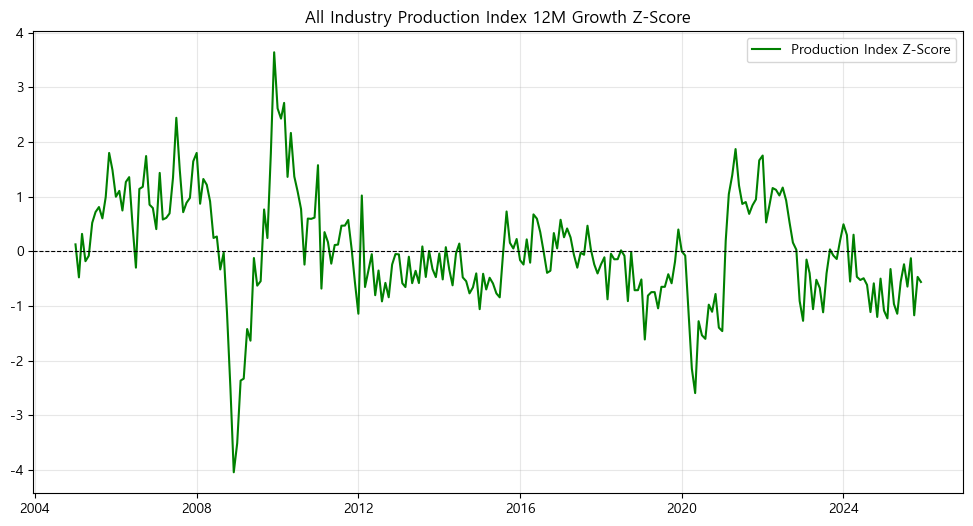

In [4]:
# 전산업 파일을 읽어옵니다.
df_credit = pd.read_csv('data/전산업생산지수(2000.1~).csv',encoding='cp949')
# 데이터 전처리 (가로 -> 세로 변환)
# 첫 번째 열이 산업 분류, 나머지 열이 날짜 데이터입니다.
dates = df_credit.columns[1:]
values = df_credit.iloc[0, 1:].values
# 데이터프레임 생성
df = pd.DataFrame({'Production_Index': values}, index=dates)
df.index.name = '날짜'
# 날짜 형식 변환 및 정렬 (예: '2025.12' -> '2025-12-01')
df.index = df.index.str.replace(r'[^\d.]', '', regex=True)
df.index = pd.to_datetime(df.index, format='%Y.%m')
df = df.sort_index()
# 날짜 범위 설정 (2004년 1월 1일부터 2026년 2월 1일까지)
start_date = '2004-01-01'
end_date = '2026-02-01'
df = df[(df.index >= start_date) & (df.index <= end_date)]
# 숫자 변환
df['Production_Index'] = pd.to_numeric(df['Production_Index'])
# 12개월 누적 로그 변화율 계산 (성장률)
df['log_val'] = np.log(df['Production_Index'])
df['12m_log_return'] = df['log_val'].diff(12)
# Z-Score 계산 (부호 반전 없음: 생산 증가 = 호재)
mean_val = df['12m_log_return'].mean()
std_val = df['12m_log_return'].std()

df['z_score'] = (df['12m_log_return'] - mean_val) / std_val
# CSV 파일 저장
output_filename = 'data/data_z_score/Production_Index_Z_Score.csv'
df.to_csv(output_filename, encoding='utf-8-sig')
print(f"'{output_filename}' 파일이 저장되었습니다.")
# 결과 확인
print(df[['Production_Index', '12m_log_return', 'z_score']].tail())
# 시각화
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['z_score'], label='Production Index Z-Score', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('All Industry Production Index 12M Growth Z-Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# 실물 지표 계산을 위한 신용카드사용액, 전산업생산지수, 소매판매액 z-score 계산 데이터 불러오기
df_credit = pd.read_csv('data/data_z_score/(사용액)신용카드_Z_Score_2005_2026.csv', index_col='date', parse_dates=True)
df_production = pd.read_csv('data/data_z_score/Production_Index_Z_Score.csv', index_col='날짜', parse_dates=True)
df_retail = pd.read_csv('data/data_z_score/new_Retail_Sales_Z_Score.csv', index_col='날짜', parse_dates=True)

In [6]:
# 데이터 통합
combined_fin = df_credit[['z_score']].rename(columns={'z_score': 'credit_spread'}).join(
    df_production[['z_score']].rename(columns={'z_score': 'industrial_production'}), how='inner').join(
    df_retail[['z_score']].rename(columns={'z_score': 'retail_sales'}), how='inner')

In [7]:
# 실물 지표 계산(평균)
combined_fin['real_index'] = combined_fin.mean(axis=1)

In [8]:
# 형식 맞추기 및 저장
final_real_output = combined_fin.reset_index().rename(columns={'index': 'date'})
final_real_output = final_real_output.dropna() # 초기 12개월분 제외

final_real_output.to_csv('data/실물지표계산.csv', index=True, encoding='utf-8-sig')
print("실물 종합지표 파일이 'data/실물지표계산.csv'로 저장되었습니다.")

실물 종합지표 파일이 'data/실물지표계산.csv'로 저장되었습니다.


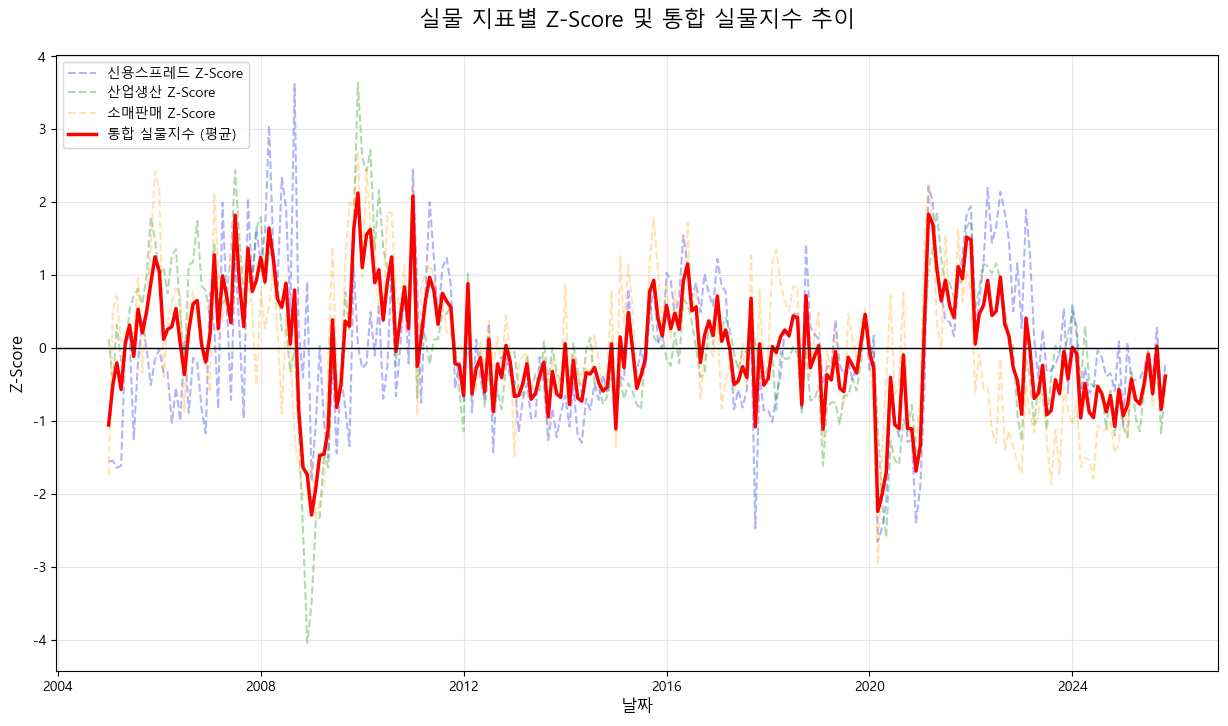

In [9]:
# 시각화
# 한글 폰트 설정 (환경에 따라 필요시 설정)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows용
# plt.rcParams['font.family'] = 'AppleGothic' # Mac용
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15, 8))

# 개별 지표들 (Credit Spread, KOSPI, Exchange) 흐릿하게 출력
plt.plot(combined_fin.index, combined_fin['credit_spread'], label='신용스프레드 Z-Score', color='blue', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['industrial_production'], label='산업생산 Z-Score', color='green', alpha=0.3, linestyle='--')
plt.plot(combined_fin.index, combined_fin['retail_sales'], label='소매판매 Z-Score', color='orange', alpha=0.3, linestyle='--')

# 통합 금융 지수 (fin_index)
plt.plot(combined_fin.index, combined_fin['real_index'], label='통합 실물지수 (평균)', color='red', linewidth=2.5)

# 기준선 (Z-score = 0) 추가
plt.axhline(0, color='black', linewidth=1, linestyle='-')

# 차트 꾸미기
plt.title('실물 지표별 Z-Score 및 통합 실물지수 추이', fontsize=16, pad=20)
plt.xlabel('날짜', fontsize=12)
plt.ylabel('Z-Score', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()